In [1]:
#!/usr/bin/env python3
#import your libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier, Pool
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost import XGBClassifier

In [2]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

### Assigning columns to specific lists (cat, num, date, etc.)

In [3]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

Total columns: 220


In [ ]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()

In [112]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

In [4]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### EDA

### Feature Engineering Class

In [7]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000]
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('after running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000]
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
        return df_feat ### delete?
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe

    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1)
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1)
        print('dropping columns: ', self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        
        self._apply_df_transform(df_feat)
        
        self._create_tuning_df(df_feat)
        self.list_drop_col = []
        self._final_df_summary()
        
    def _shuffle_df(self, X, y):
        '''shuffle dataframe'''
        y = pd.Series(y)
        X = pd.DataFrame(X)
        df_temp = pd.concat([X, y], keys=['features','target'], axis=1)
        df_temp = shuffle(df_temp).reset_index(drop=True)
        X = df_temp.features
        y = df_temp.target
        return X, y
        
    def _final_df_summary(self):
        print("final dataframe created.")
        print("To test a model use the mod.create_df_score_model(model_current)")
        print("method where, for example, model_current=LogisticRegression().")

    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        X_train, X_test, y_train, y_test = self._split_dataframe(X, y)
        X_train, y_train = self._apply_downsampling(X_train, y_train) # apply only train set
        X_train, y_train = self._apply_smote(X_train, y_train)        # apply only train set
        
        X_train, y_train = self._shuffle_df(X_train, y_train)
        
        mod.X_train, mod.y_train = self._apply_pca(X_train, y_train)          # apply to train set
        mod.X_test , mod.y_test = self._apply_pca(X_test, y_test) 
        
#         X_train, y_train = self._apply_pca(X_train, y_train)          # apply to train set
#         X_test, y_test = self._apply_pca(X_test, y_test)              # apply to test set
#         mod.X_train, mod.y_train = X_train, y_train
#         mod.X_test , mod.y_test = X_test, y_test

    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            print("creating tuning dataframe...")
            X, y = self._drop_col_id_target(df_feat)
            X, y = self._apply_downsampling(X, y)
            X, y = self._apply_smote(X, y)
            mod.X_features, mod.y_target = self._shuffle_df(X, y)
        else:
            print('bool_create_tuning_df set to false.')

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.1, 
                                                            random_state=42)
        return X_train, X_test, y_train, y_test
        
    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_downsampling(self, X, y):
        '''down sampling majority class'''
        if bool_apply_downsampling:
            len_y_one = len(y[y==1])
            sampler = RandomUnderSampler(random_state=42, ratio={0:95000, 1:len_y_one})
            X, y = sampler.fit_sample(X, y)
            print("downsampling applied.")
            return X, y
        else:
            print("bool_apply_downsampling set to false.")
            return X, y
            
    def _apply_smote(self, X, y):
        '''applying smote to split training set'''
        if bool_apply_smote:
            sm = SMOTE(random_state=42, n_jobs=-1)
            X, y = sm.fit_sample(X, y)
            print("smote applied.")
            return X, y
        else:
            print("bool_apply_smote set to false.")
            return X, y
            
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X = self._pca(X)
            print('pca applied to training set, then test set.')
            return X, y
        else:
            print("bool_apply_pca set to false.")
            return X, y

    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca
        
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if (col in df_features.columns):    
                self.list_drop_col.append(col) 
        else:
            print("keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values)
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if (non_fraud_total==0):
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat
    
mod = Model()
fe = FeatureEngineering()

bool_predict_proba = False

bool_apply_pca = False
bool_apply_smote = True
bool_apply_downsampling = True

bool_create_tuning_df = True
bool_drop_col = True
df_feat_1000 = False
fe.final_features(bool_drop_col, list_feat=['addr1','addr2','card2','card3','C1','P_emaildomain', 
                                            'card6', 'V294','V279','C14','V306','D2','D10'])
bool_drop_col = False
fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1','D3','D4','D11'])
fe.list_drop_col.append('C4')
fe.create_final_df()

# fe.feature_testing(bool_drop_col, list_feat=['addr1'])

# FN = 540, FP = 12598.0, pca, smote, downsampling
# FN = 534.0, FP = 12535.0, pca, smote 
# FN = 577.0, FP = 22223.0, smote and downsampling only
# FN = 360, FP = 30387.0, smote only
# FN = 2103.0, FP = 36.0, undersampling only 
# FN = 508.0, FP = 8724.0, full, pca, smote
# FN = 508, FP = 8745, full, pca, smote, undersample, 50,000 samples
# FN = 510, FP = 8701, full, pca, smote, undersample, 25,000 samples
# FN = 1093, FP = 734, full, pca, smote, undersample, 50,000 samples, correction
# FN = 360, FP = 30387, smote
# FN = 354, FP = 31090, smote, undersample
# FN = 572, FP = 30741, smote, undersample, pca
# FN = 485, FP = 30076, smote, undersample, pca, 100000
# FN = , FP = , smote, undersample, pca, 95000, full
# FN = 360, FP = 30387, no downsample, no pca, smote addr1
# FN = 529, FP = 18023, smote, full
# FN = 429, FP = 23106, smote, downsample, full
# FN = 549, FP = 30123, smote, downsample, pca, full
# FN = 545, FP = 30227, smote, downsample, pca, 290, full

# NEXT, we need to fix our tuning dataframe. method, decide how we are going to tune our model, then 
# we also need to decide how this effects our results. Should we tune on the hold outset? If we applied
# smote and undersampling, etc. how does this effect our outcome?

# the tuning dataframe we define must upsample and downsample from whole dataset, we use that to 
# tune our data since during the process of tuning, we will have our hold out set in the CV. 
# Also, check time elap for non pca. 

after running final_features, run create_final_df.
after running final_features, run create_final_df.
keeping original feature card5
keeping original feature V317
keeping original feature V69
keeping original feature D1
keeping original feature D3
keeping original feature D4
keeping original feature D11
dropping columns:  ['addr1', 'addr2', 'card2', 'card3', 'C1', 'V294', 'V279', 'C14', 'V306', 'D2', 'D10', 'C4']
downsampling applied.
smote applied.
bool_apply_pca set to false.
bool_apply_pca set to false.
creating tuning dataframe...
downsampling applied.
smote applied.
final dataframe created.
To test a model use the mod.create_df_score_model(model_current)
method where, for example, model_current=LogisticRegression().


In [9]:
print('X_train', mod.X_train.shape)
print('y_train',mod.y_train.shape)
print('X_test',mod.X_test.shape)
print('y_test',mod.y_test.shape)
print('y_train==1',np.sum(mod.y_train[mod.y_train==0].isnull()))
print('y_train==0',np.sum(mod.y_train[mod.y_train==1].isnull()))
# we need to test tuning on the entire dataframe and also the split version we have created. 
# lets test using logisticregression.

X_train (190000, 291)
y_train (190000, 1)
X_test (59054, 291)
y_test (59054,)
y_train==1 0    95000
dtype: int64
y_train==0 0    95000
dtype: int64


In [10]:
print('X_features', mod.X_features.shape)
print('y_target',mod.y_target.shape)

X_features (190000, 291)
y_target (190000, 1)


,0
0,1
1,1
2,1
3,0
4,0
...,...
189995,1
189996,1
189997,0
189998,1


In [318]:
# Testing split, then finalized and moving onto tuning.
bool_predict_proba = False
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)
roc score: 0.6803990865550728

The following new features have been created: ['addr1_fe', 'addr2_fe', 'card2_fe', 'card3_fe', 'C1_fe', 'P_emaildomain_fe', 'card6_fe', 'V294_fe', 'V279_fe', 'C14_fe', 'V306_fe', 'D2_fe', 'D10_fe', 'card5_fe', 'V317_fe', 'V69_fe', 'D1_fe', 'D3_fe', 'D4_fe', 'D11_fe'] 

              precision    recall  f1-score   support

           0       0.99      0.53      0.69     56945
           1       0.06      0.83      0.11      2109

    accuracy                           0.55     59054
   macro avg       0.52      0.68      0.40     59054
weighted avg       0.96      0.55      0.67     59054


Printing df_scores...

      feat_tested     fn      

In [173]:
# model_lr_temp = LogisticRegression(random_state=42, n_jobs=-1)
# model_lr_temp.fit(mod.X_train, mod.y_train)
# pred_lr = model_lr_temp.predict(mod.X_test)
# print(confusion_matrix(mod.y_test, pred_lr))
# print(roc_auc_score(mod.y_test, pred_lr))

In [182]:
#####

In [317]:
mod.X_train = pd.DataFrame(mod.X_train)
mod.y_train = pd.DataFrame(mod.y_train)
mod.X_test = pd.DataFrame(mod.X_test)
mod.y_test = pd.DataFrame(mod.y_test)
mod.X_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv')
mod.y_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv')
mod.X_test.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv')
mod.y_test.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv')
mod.X_features = pd.DataFrame(mod.X_features)
mod.y_target = pd.DataFrame(mod.y_target)
mod.X_features.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')


In [319]:
mod.X_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv')
mod.y_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv')
mod.X_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv')
mod.y_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv')
mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')


In [103]:
mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')
mod.X_features = mod.X_features.drop('Unnamed: 0', axis=1)
mod.y_target = mod.y_target.drop('Unnamed: 0', axis=1)

In [238]:
# mod.X_features.info(memory_usage='deep')
# mod.y_target.info(memory_usage='deep')

In [8]:
bool_predict_proba = True
model_current = LogisticRegression(random_state=42)
mod.create_df_score_model(model_current)


Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
threshold:  0.1
roc auc score: 0.5199051050440433
confusion matrix:
 [[ 2483 54462]
 [    8  2101]]
threshold:  0.15
roc auc score: 0.5423389076188869
confusion matrix:
 [[ 5443 51502]
 [   23  2086]]
threshold:  0.2
roc auc score: 0.5630077660970813
confusion matrix:
 [[ 8472 48473]
 [   48  2061]]
threshold:  0.25
roc auc score: 0.5831585725222707
confusion matrix:
 [[11469 45476]
 [   74  2035]]
threshold:  0.3
roc auc score: 0.6004644287340888
confusion matrix:
 [[14466 42479]
 [  112  1997]]
threshold:  0.35
roc auc score: 0.6195614620031532
confusion matrix:
 [[17748 39197]
 [  153  1956]]
threshold:  0.4
roc auc score: 0.6379032890953442
confusio

Fitting model:
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
threshold:  0.1
roc auc score: 0.7049145438722639
confusion matrix:
 [[31384 25561]
 [  298  1811]]
threshold:  0.15
roc auc score: 0.751985055747227
confusion matrix:
 [[40714 16231]
 [  445  1664]]
threshold:  0.2
roc auc score: 0.751985055747227
confusion matrix:
 [[40714 16231]
 [  445  1664]]
threshold:  0.25
roc auc score: 0.751985055747227
confusion matrix:
 [[40714 16231]
 [  445  1664]]
threshold:  0.3
roc auc score: 0.7669717450489294
confusion matrix:
 [[47146  9799]
 [  620  1489]]
threshold:  0.35
roc auc score: 0.7587608783416373
confusion matrix:
 [[50072  6873]


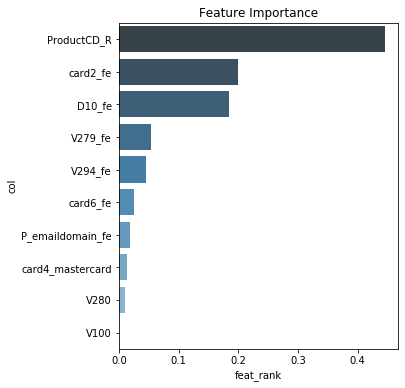

                col  feat_rank
0       ProductCD_R   0.445391
1          card2_fe   0.200286
2            D10_fe   0.185126
3           V279_fe   0.054042
4           V294_fe   0.045456
5          card6_fe   0.025921
6  P_emaildomain_fe   0.018616
7  card4_mastercard   0.014196
8              V280   0.010655
9              V100   0.000310


In [13]:

model_current = DecisionTreeClassifier(random_state=42, max_depth=4)
mod.create_df_score_model(model_current)


In [8]:
# bool_predict_proba = False
# model_current = RandomForestClassifier(random_state=42, n_jobs=-1)
# mod.create_df_score_model(model_current)

In [40]:
# bool_predict_proba = False
# model_current = LogisticRegression(random_state=42)
# mod.create_df_score_model(model_current) 


In [6]:
class Model():
    def __init__(self):
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        
    def create_df_score_model(self, model_current):
        '''scores model'''
        print("Fitting model:\n", model_current)
        y_pred, elapsed_time = self.add_model(model_current) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, 
                                                       elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model_current)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred = self._predict(model)
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            y_pred = self._predict_proba(model)
            return y_pred 
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred
        
    def _predict_proba(self, model):
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            y_pred_class = self._predict_proba_threshold(y_pred_prob)
            return y_pred_class
        except:
            print("Model does not have predict_proba attribute.")
            
    def _predict_proba_threshold(self, y_pred_prob):
        for threshold in [.1, .15, .2, .25, .3, .35, .4, .45, .5]:
            print('threshold: ', threshold)
            y_pred_class = binarize(y_pred_prob, threshold)[:,1]
            print('roc auc score:', roc_auc_score(mod.y_test, y_pred_class))
            print('confusion matrix:\n', confusion_matrix(mod.y_test, y_pred_class))
        return y_pred_class
            
#     def _create_roc_curve(self, y_pred_class):
#         fpr, tpr, thresholds = roc_curve(mod.y_test, y_pred_class)
#         plt.plot(fpr, tpr)
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.0])
#         plt.title("ROC curve for classifier")
#         plt.xlabel("False Positive Rate (1 - Specificity)")
#         plt.ylabel("True Positive Rate (Sensitivity)")
#         plt.grid(True)
#         plt.show()
        
    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time = self._calc_scores(y_pred, 
                                                                  elapsed_time)        
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_recall, col_precision, df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print("roc auc score:", roc_auc_score(mod.y_test, y_pred))
        return col_recall, col_precision, col_time
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:", fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print(classif_report)
        print('\nPrinting df_scores...\n\n', df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            df_feat_rank = self._feat_import_create_df(model)
            self._feat_import_create_plot(df_feat_rank)
            print(df_feat_rank[0:10].reset_index(drop=True))
        except:
            print("\nmodel does not have _feature_importance attribute.")
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(fe.df_feat.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        plt.figure(figsize=(5,6))
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        
mod = Model()

In [106]:
# model_xgbc = XGBClassifier()
# model_xgbc.fit(mod.X_train, mod.y_train)
# y_pred_xgbc = model_xgbc.predict(mod.X_test)
# print(classification_report(mod.y_test, y_pred_xgbc))
# print(confusion_matrix(mod.y_test, y_pred_xgbc))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     56954
           1       0.84      0.77      0.80     57022

    accuracy                           0.81    113976
   macro avg       0.81      0.81      0.81    113976
weighted avg       0.81      0.81      0.81    113976

[[48297  8657]
 [12938 44084]]


In [ ]:
# model_cbc = CatBoostClassifier()
# X_test
# model_cbc.fit(mod.X_train, mod.y_train)
# # y_pred_cbc = model_cbc.predict(mod.y_test)
# # print(classification_report(mod.y_test, y_pred_cbc))
# # print(confusion_matrix(mod.y_test, y_pred_cbc))
# test_data = Pool(mod.X_test)
# y_pred_cbc = model_cbc.predict(test_data)
# print(classification_report(mod.y_test, y_pred_cbc))
# print(confusion_matrix(mod.y_test, y_pred_cbc))


In [237]:
# base model
model_lr_temp = LogisticRegression(random_state=42, n_jobs=-1)
model_lr_temp.fit(mod.X_train, mod.y_train)
pred_lr = model_lr_temp.predict(mod.X_test)
print(confusion_matrix(mod.y_test, pred_lr))
print(roc_auc_score(mod.y_test, pred_lr))
# NEXT, we fixed our downsample and upsamp

[[48301  8653]
 [13502 43520]]
0.8056422853051062


In [239]:
model_lr_temp.fit(mod.X_train, mod.y_train)
pred_lr = model_lr_temp.predict(mod.X_test)
print(confusion_matrix(mod.y_test, pred_lr))
print(roc_auc_score(mod.y_test, pred_lr))

[[48301  8653]
 [13502 43520]]
0.8056422853051062


## Model Tuning

#### RFC Tuning

#### Manual Tuning - XGBClassifier

In [ ]:
##############################

In [155]:
# mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(mod.X_features[0:10000], 
#                                                                     mod.y_target[0:10000], 
#                                                                     test_size=0.1, 
#                                                                     random_state=42)
mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(mod.X_features, 
                                                                    mod.y_target, 
                                                                    test_size=0.1, 
                                                                    random_state=42)

In [ ]:
##############################

In [ ]:
### Tuning XGBClassifier READY ###
print('tuning xgbc')
xgbc = XGBClassifier(n_jobs=-1, random_state=42)

max_depth = [2,3,5,7,9,11,13]
# learning_rate = [0,.1,.3,.5,.7,.9]
booster = ['gbtree', 'gblinear', 'dart']
subsample = [.1,.3,.5,.7]
colsample_bytree = [.1,.3,.5,.7]
colsample_bylevel = [0,.1,.3,.5,.7,.9,1]
colsample_bynode = [.1,.3,.5,.7]
reg_alpha = [0,1,3,5,7]
reg_lambda = [1,3,5,7]
scale_pos_weight = [1,3,5,7]
base_score = [.1,.2,.3,.4,.5]

hyperparameters = dict(max_depth=max_depth, 
#                        learning_rate=learning_rate, 
                       booster=booster, 
                       subsample=subsample, 
                       colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, 
                       colsample_bynode=colsample_bynode, reg_alpha=reg_alpha, reg_lambda=reg_lambda, 
                       scale_pos_weight=scale_pos_weight,
                       base_score=base_score
                      )

clf = RandomizedSearchCV(xgbc, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best booster:', best_model.best_estimator_.get_params()['booster'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print('Best colsample_bytree:', best_model.best_estimator_.get_params()['colsample_bytree'])
print('Best colsample_bylevel:', best_model.best_estimator_.get_params()['colsample_bylevel'])
print('Best colsample_bynode:', best_model.best_estimator_.get_params()['colsample_bynode'])
print('Best reg_alpha:', best_model.best_estimator_.get_params()['reg_alpha'])
print('Best reg_lambda:', best_model.best_estimator_.get_params()['reg_lambda'])
print('Best scale_pos_weight:', best_model.best_estimator_.get_params()['scale_pos_weight'])
print('Best base_score:', best_model.best_estimator_.get_params()['base_score'])



tuning xgbc
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 7.5min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.986, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.3min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.985, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 28.2min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.0min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.2min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.988, total= 6.2min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 40.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.3min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 46.7min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.3min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 53.0min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.4min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 59.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.988, total= 6.6min
[CV] subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4 
[CV]  subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4, score=0.966, total= 2.6min
[CV] subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4 
[CV]  subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4, score=0.964, total= 2.6min
[CV] subsample=0.7, scale_pos_weigh

[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.796, total= 1.6min
[CV] subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5 
[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.804, total= 1.6min
[CV] subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5 
[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.802, total= 1.7min
[CV] subsample=0.5, s

[CV]  subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3, score=0.984, total= 2.4min
[CV] subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3 


In [ ]:
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)

In [ ]:
###### testing manual tuning ######
### manual xbgc tuning
max_depth = [3,5,7,9,11,13]
max_depth = [1,3,5]
list_time_elapsed = []
list_roc_auc_score = []
for val in max_depth:
    model_xgbc = XGBClassifier(max_depth=val, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    model_xgbc.fit(mod.X_train_test, mod.y_train)
    y_pred_xgbc = model_xgbc.predict(mod.X_test)
    elapsed_time = (time.time() - start_time) / 60
    
    score_roc_auc = roc_auc_score(mod.y_test, y_pred_xgbc)
    print(score_roc_auc) #delete
    list_time_elapsed.append(elapsed_time)
    list_roc_auc_score.append(score_roc_auc)
    print('max depth: ', val)
    print(confusion_matrix(mod.y_test, y_pred_xgbc))

col_time_elapsed = pd.Series(list_time_elapsed)
col_roc_score = pd.Series(list_roc_auc_score)
col_max_depth = pd.Series(max_depth)
df_results_xgbc = pd.concat([col_max_depth, col_roc_score,col_time_elapsed], 
                            keys=['max_depth', 'roc_auc_score', 'time_elap'], 
                            axis=1)
print(df_results_xgbc)

sns.lineplot(x='max_depth', y='roc_auc_score', data=df_results_xgbc)
plt.title("XGBC manual tuning")
plt.show()

In [9]:
#### Tuning RandomForestClassifier READY ####
rfc = RandomForestClassifier(oob_score=False, n_jobs=1, random_state=42, verbose=1)

n_estimators = [50,75,100,125,150,200]
criterion = ['gini', 'entropy']
max_depth = [3,5,7,9,11,13,15]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,2,4,6,8,10]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [2,3,5,7,9,None]
min_impurity_decrease = [0,.1,.3,.5,.7,.9]

# n_estimators = [50,75,100,125]
# criterion = ['gini']
# max_depth = [2,3,4,5,6,7,None]
# min_samples_split = [6,7,8,9]
# min_samples_leaf = [1,2]
# min_weight_fraction_leaf = [0]
# max_features = ['auto', 'sqrt', 'log2', None]
# max_leaf_nodes = [None]
# min_impurity_decrease = [0]

hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                       min_impurity_decrease=min_impurity_decrease
                      )

clf = RandomizedSearchCV(rfc, hyperparameters, random_state=42, cv=5, verbose=5, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes'])
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease'])


In [267]:
###### testing manual tuning ######
### manual lr tuning

penalty = ['l1', 'l2', 'elasticnet','none']

list_time_elapsed = []
list_roc_auc_score = []
for val in penalty:
    model = LogisticRegression(penalty=val, n_jobs=1, random_state=42)
    
    start_time = time.time()
    model.fit(mod.X_train, mod.y_train)
    y_pred = model.predict(mod.X_test)
    elapsed_time = (time.time() - start_time) / 60
    
    score_roc_auc = roc_auc_score(mod.y_test, y_pred)
    print(score_roc_auc) #delete
    list_time_elapsed.append(elapsed_time)
    list_roc_auc_score.append(score_roc_auc)
    print('penalty: ', val)
    print(confusion_matrix(mod.y_test, y_pred))

col_time_elapsed = pd.Series(list_time_elapsed)
col_roc_score = pd.Series(list_roc_auc_score)
col_penalty = pd.Series(penalty) ### UPDATE
df_results = pd.concat([col_max_depth, col_roc_score,col_time_elapsed], 
                            keys=['penalty', 'roc_auc_score', 'time_elap'], 
                            axis=1)
print(df_results)

sns.lineplot(x='penalty', y='roc_auc_score', data=df_results_xgbc)
plt.title("lr manual tuning")
plt.show()

KeyboardInterrupt: 

In [265]:
print(mod.X_features_test.shape)
print(mod.y_target_test.shape)

(1000, 291)
(1000, 1)


In [277]:
#### LR Tuning ####
lr = LogisticRegression(random_state=42)

penalty = ['l1', 'l2', 'elasticnet','none']
tol = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
C = [1e-1,.2,.3,.5,.7,1]
fit_intercept = [True,False]
intercept_scaling = [1,.1,.01,.001]
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'sag']#, 'liblinear','saga']
max_iter = [50,75,100,150,200]
multi_class = ['auto', 'ovr', 'multinomial']
l1_ratio = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]


hyperparameters = dict(penalty=penalty, 
#                        tol=tol, 
#                        C=C, 
#                        fit_intercept=fit_intercept,
#                        intercept_scaling=intercept_scaling, 
#                        class_weight=class_weight,
#                        solver=solver, 
                       max_iter=max_iter
#                        multi_class=multi_class, 
#                        l1_ratio=l1_ratio
                      )

clf = RandomizedSearchCV(lr, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)
# best_model = clf.fit(mod.X_features_test, mod.y_target_test) #testing

# best hyper parameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best tol:', best_model.best_estimator_.get_params()['tol'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best fit_intercept:', best_model.best_estimator_.get_params()['fit_intercept'])
print('Best intercept_scaling:', best_model.best_estimator_.get_params()['intercept_scaling'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Best multi_class:', best_model.best_estimator_.get_params()['multi_class'])
print('Best l1_ratio:', best_model.best_estimator_.get_params()['l1_ratio'])


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] penalty=l1, max_iter=50 .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][CV] ............. penalty=l1, max_iter=50, score=0.878, total=  51.7s
[CV] penalty=l1, max_iter=50 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.7s remaining:    0.0s


[LibLinear][CV] ............. penalty=l1, max_iter=50, score=0.882, total=  44.6s
[CV] penalty=l1, max_iter=50 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[LibLinear][CV] ............. penalty=l1, max_iter=50, score=0.904, total=  21.5s
[CV] penalty=l1, max_iter=50 .........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s


[LibLinear][CV] ............. penalty=l1, max_iter=50, score=0.910, total= 1.1min
[CV] penalty=l1, max_iter=50 .........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.1min remaining:    0.0s


[LibLinear][CV] ............. penalty=l1, max_iter=50, score=0.912, total= 2.0min
[CV] penalty=l1, max_iter=50 .........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.1min remaining:    0.0s


[LibLinear][CV] ............. penalty=l1, max_iter=50, score=0.913, total=  57.1s
[CV] penalty=l1, max_iter=50 .........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.0min remaining:    0.0s


[LibLinear][CV] ............. penalty=l1, max_iter=50, score=0.914, total= 1.1min
[CV] penalty=l1, max_iter=50 .........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  7.1min remaining:    0.0s


[LibLinear][CV] ............. penalty=l1, max_iter=50, score=0.913, total= 1.1min
[CV] penalty=l1, max_iter=50 .........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  8.2min remaining:    0.0s


[LibLinear][CV] ............. penalty=l1, max_iter=50, score=0.910, total= 1.0min
[CV] penalty=l1, max_iter=50 .........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  9.3min remaining:    0.0s


[LibLinear]

KeyboardInterrupt: 

In [239]:
# plt.hist(mod.y_target)

In [250]:
# np.sum(mod.y_target[mod.y_target==0].isnull())
df_temp = pd.concat([mod.X_features, mod.y_target], keys=['features','target'],axis=1).sample(n=1000)

In [252]:
mod.X_features_test = df_temp.features
mod.y_target_test = df_temp.target

In [253]:
#### Tuning DTC READY ####
dt = DecisionTreeClassifier(random_state=42)

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3,5,7,9,11]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,3,5,7,9]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
class_weight = ['balanced', None]

hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, 
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, class_weight=class_weight
                      )

clf = RandomizedSearchCV(dt, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)
# best_model = clf.fit(mod.X_features_test, mod.y_target_test) #testing
 
# best hyper parameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Batch computation too fast (0.1750s.) Setting batch_size=2.
[Parallel(n_jobs=3)]: Done  27 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Batch computation too fast (0.0297s.) Setting batch_size=26.


Best criterion: entropy
Best splitter: best
Best max_depth: 11
Best min_samples_split: 5
Best min_samples_leaf: 9
Best min_weight_fraction_leaf: 0
Best max_features: None
Best class_weight: balanced


[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    3.9s finished


In [483]:
### Tuning CatBoost READY ###
# Tune learning rate manually.
cbc = CatBoostClassifier(random_state=42)

max_depth = [2,3,5,7,9,11,13]
learning_rate = [.1,.3,.5,.7,.9]
# bagging_temperature = []
subsample = [1,3,5,7]
n_estimators = [50,75,100,150]
depth = [2,4,6,8,10]
grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']


hyperparameters = dict(max_depth=max_depth, 
                       learning_rate=learning_rate, 
                       n_estimators=n_estimators,
                       subsample=subsample,
                       depth=depth,
                       grow_policy=grow_policy
                      )

clf = RandomizedSearchCV(cbc, hyperparameters, random_state=42, cv=5, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/krahman/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/krahman/opt/anaconda3/lib/python3.7/pickle.py", line 549, in save
    self.save_reduce(obj=obj,

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 13.5min


CatBoostError: catboost/private/libs/options/bootstrap_options.cpp:5: Taken fraction should in in (0,1]

In [21]:
# cbc.fit(x)
mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(mod.X_features, 
                                                                    mod.y_target, 
                                                                    test_size=0.1, 
                                                                    random_state=42)

In [108]:
# cbc.fit(mod.X_train, mod.y_train)

In [ ]:
pred_cbc = cbc.predict(mod.X_test)
confusion_matrix(y_test, pred_cbc)


In [89]:
# bool_predict_proba = False
# # tuned model
# current_model = RandomForestClassifier(
#                        max_depth=3, max_features='log2',
#                        min_impurity_decrease=0.0, 
#                        min_samples_leaf=1, min_samples_split=7,
#                        min_weight_fraction_leaf=0.0, n_estimators=50,
#                        n_jobs=-1, oob_score=False, random_state=42,
#                        verbose=0, warm_start=False)
# mod.create_df_score_model(model_current)

# # base model
# current_model = RandomForestClassifier(random_state=42, n_jobs=-1)
# mod.create_df_score_model(model_current)

In [ ]:
# model.create_df_score_model(df_feat)
# 369.0 all col
# 398.0 remove P_emaildomain
# 410.0 remove card6
# 395.0 drop C4
# 415.0 add all back in
# 368.0 test again with C14


In [ ]:
# create feature from TransactionAmt. Add more EDA information. 



In [ ]:
# 1. Model Tuning
# 2. Finished - Features
# 3. more EDA
# 4. Finished - move pca and smote into fe. 

In [ ]:
df_temp_read = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
df_temp_read[len(df_temp_read)-40:]

In [ ]:
# # it reads the csv, creates a dataframe, then appends the results, then saves over the old version and keeps
# # a record of all columns in the tested dataframe.

# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

# # we want to test a feature for feature engineering... we must 

# for col_original, col_new in zip(list_col, fe.list_new_feat):
#     print(col_original, col_new)
#     X[col_new] = fe.df_feat[col_new]
#     X = X.drop(col_original, axis=1)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     start_time = time.time()

#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
#     X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    
#     model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
#     model_lr_pca_sm.fit(X_train_res, y_train_res)
    
#     y_pred = model_lr_pca_sm.predict(X_test)     # predict
    
#     elapsed_time = time.time() - start_time
#     print('\nTime elapsed:', elapsed_time / 60)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
    
# #     X = X.drop(col, axis=1)
#     print(list(X.columns))

In [ ]:
# fe.df_feat['time_delta'] = df_temp['time_delta']
# fe.df_feat['time_delta_week'] = df_temp['time_delta']/7
# fe.df_feat['time_delta_month'] = df_temp['time_delta']/30
# fe.df_feat

In [ ]:
##### implement into feature engineering class. days lapsed
df_temp = fe.df_feat[['TransactionDT']]
df_temp['time_delta'] = 0
len_df_temp = df_temp.shape[0]
for i in range(1,len(df_temp['TransactionDT'][0:len_df_temp])):
    val_time_1 = df_temp.loc[i - 1, 'TransactionDT']
    val_time_2 = df_temp.loc[i, 'TransactionDT']
    val_time_delta = val_time_2 - val_time_1
    df_temp.loc[i, 'time_delta'] = val_time_delta
    
    

In [ ]:
# KEEP
# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [ ]:
# notes, do we need to visualize our results?? We need to look at our confusion matrix
# and decide how to improve our results from here... Test and see what happens if we 
# increase our principal components... test removing columns, adding columns, imputing
# certain columns all together. 

# test imputing 500 or less for ohe. Then test dropping card1 due to its number
# of unique values that would make our data very high dimensional. We can try only ohe for
# the entire dataset to see how our model performs over all... Though.. it will likely run 
# out of memory and crash. 

# ALSO test probabilities on logisticregression


In [ ]:
# %matplotlib inline
# plt.rcParams['font.size'] = 14

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
# plt.hist(y_pred_prob[:,1], bins=8)
# plt.xlim(0,1)
# plt.title("Histogram of Probability of Fraud")
# plt.xlabel("Predicted probability of Fraud")
# plt.ylabel("Frequency")

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
e

# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

# fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
# plt.plot(fpr, tpr)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.title("ROC curve for fraud detection classifier")
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity)")
# plt.grid(True)
# plt.show()

In [ ]:
# def evaluate_threshold(threshold):
#     print("Sensitivity:", tpr[thresholds > threshold][-1])
#     print("Specificity:", 1 - fpr[thresholds > threshold][-1],'\n')
    
# evaluate_threshold(.5)
# evaluate_threshold(.2)
# evaluate_threshold(.1)

# print(roc_auc_score(y, y_pred_prob[:,1]))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_test2) # actual prediction test data set
# print('y_pred_actual on test set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y_test2, y_pred_actual))
# print(classification_report(y_test2, y_pred_actual))

# print('y_pred_proba\n')
# y_pred_proba = model_lr_pca.predict_proba(X_test2)
# y_pred_class = binarize(y_pred_proba, 0.5)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y_test2, y_pred_class))
# print(classification_report(y_test2, y_pred_class))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_pca) # actual full data set
# print('Logistic Regression')
# print('y_pred_actual full data set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y, y_pred_actual))
# print(classification_report(y, y_pred_actual))

# print('y_pred_proba full data set\n')
# y_pred_proba = model_lr_pca.predict_proba(X_pca)#[:,1]#[0:10]
# y_pred_class = binarize(y_pred_proba, 0.2)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

In [ ]:
# sns.barplot(x='TransactionDT', y='TransactionDT', hue='isFraud', data=df_features)
# plt.title("Transaction Date Versus Fraud")
# plt.show()

# we want to figure out how to create more features from TransactionDT.. 
# are certain transactions more likely. in general, to be fraudualant around a certain day? 
# we have transactionID yet we dont have the specific card of who it belongs to.. 
# if card1 is the unique identifier... and we did a groupby on fraud.. 
# we have average spent per day as an option... 
# create a feature that is average spent per day for non fraud versus average spent per day for fraud.. 
# what would the describe method reveal for us? 